<div>
    <a href="../notebook/2. Data Analysis.ipynb" style="float: left; padding: 10px; background-color: #007bff; color: white;">Previous</a>
    <a href="../notebook/1. Business & Data Understanding.ipynb" style="float: right; padding: 10px; background-color: #007bff; color: white"> Next </a>
</div>

## Section 4 | Data Modeling

Data modeling is the process of selecting and training a machine learning (ML) model to learn patterns from data so it can make predictions or decisions.

---

#### Data ETL

Proses ETL yang serupa dengan bagian `Data Analysis` sebelumnya juga dilakukan dalam bagian ini karena:
1. Data yang relevan untuk membangun model ML juga bersumber dari dataset yang sama, dan
2. Lebih memastikan bahwa manipulasi data yang dilakukan dalam bagian sebelumnya tidak berdampak ke dalam bagian-bagian berikutnya

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
  
iranian_churn = fetch_ucirepo(id=563) 
  
features = iranian_churn.data.features 
target = iranian_churn.data.targets 

dataset = pd.concat(
    objs=[features, target],
    axis=1
)

dataset.head(n=5)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


---

### Data Preprocessing

[Data preprocessing](https://en.wikipedia.org/wiki/Data_preprocessing) can refer to manipulation, filtration or augmentation of data before it is analyzed —in this case, by the machine learning algorithm.

* The preprocessing pipeline used can often have large effects on the conclusions drawn from the downstream analysis. Thus, representation and quality of data perlu dieksplor before running any analysis, sebagaimana yang telah dilakukan pada keseluruhan bagian `Data Analysis` sebelumnya.
* Often, data preprocessing is the most important phase of a machine learning project. If there is a high proportion of irrelevant and redundant information present or noisy and unreliable data, then knowledge discovery during the training phase may be more difficult. 
* The well-known concept of “garbage in — garbage out” applies 100% to any task in machine learning. Any experienced professional can recall numerous times when a simple model trained on high-quality data was proven to be better than a complicated multi-model ensemble built on data that wasn’t clean.

Sehingga pada dasarnya bagian ini adalah pengulangan dan penambahan dari temuan anomali dalam dataset yang ditemukan dari bagian sebelumnya.

#### Train-Test Split

Learning the parameters of a prediction —in this context, classification— function and testing it on the same data is a [methodological mistake](https://scikit-learn.org/stable/modules/cross_validation.html): a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. 

This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set `X_test`, `y_test`.

In [2]:
from sklearn.model_selection import train_test_split

df = dataset.copy()
df = df.drop_duplicates(keep="first")

# Arbitrary random state ditetapkan sesuai dengan bagian "Data Analysis" sebelumnya
arbitrary_random_state = 0

X, y = df.drop(columns="Churn"), df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=arbitrary_random_state, 
    stratify=y
)

print("Dataset Dimensionality:")
display(
    pd.DataFrame(
        data={
            "Dataset": ["X_train", "X_test", "y_train", "y_test"],
            "Row (n)": [X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]],
            "Row (%)": [round(number=X_train.shape[0] / df.shape[0] * 100), 
                        round(number=X_test.shape[0] / df.shape[0] * 100),
                        round(number=y_train.shape[0] / df.shape[0] * 100),
                        round(number=y_test.shape[0] / df.shape[0] * 100)]
        }
    ).set_index(keys="Dataset")
)

print("Class Proportions:")
display(
    pd.DataFrame(
        data={
            "Dataset": round(number=y.value_counts(normalize=True) * 100, ndigits=3),
            "y_train": round(number=y_train.value_counts(normalize=True) * 100, ndigits=3),
            "y_test": round(number=y_test.value_counts(normalize=True) * 100, ndigits=3)
        }
    ).rename(
        index={
            0: "False (%)",
            1: "True (%)"
        }
    ).T
)

Dataset Dimensionality:


,Row (n),Row (%)
Dataset,,
X_train,2137,75
X_test,713,25
y_train,2137,75
y_test,713,25


Class Proportions:


Churn,False (%),True (%)
Dataset,84.351,15.649
y_train,84.371,15.629
y_test,84.292,15.708


Note:
* *Redundant column and duplicated data from previous findings are propagated here, since any duplications would potentially not be detected after splitting the dataset.*
* `X` designated sebagai kumpulan feature dalam dataset, sedangkan `y` adalah instance dari target variabel `Churn`
* Kedua variabel instance ini kemudian dipisahkan lebih jauh menggunakan `train_test_split`.
    * *pada bagian ini dan seterusnya, penerapan dari metode machine learning yang digunakan akan berfokus dari library [Scikit-learn](https://scikit-learn.org/stable/)*
    * fungsi ini sebenarnya adalah wrapper dari `ShuffleSplit` iterator dalam library Scikit-learn yang generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.
    * sample yang dimaksud adalah instance/row dari dataset, sehingga proses split tidak mengubah jumlah kolom dari dataset awal
    * It is possible to control the randomness for reproducibility of the results by modifying the `random_state` parameter. dalam project ini, yang diterapkan adalah passing an integer number of `arbitrary_random_state` from previous section.
* secara default, parameter `test_size` dalam `train_test_split` diatur sebanyak `0.25`, sehingga ukuran proporsi dari tiap `X_test` dan `y_test` adalah `25%` dari keseluruhan dataset
* sedangkan parameter `stratify` digunakan untuk returns the data `y` in a stratified fashion: the set contains approximately the same percentage of samples of each target class as the complete set. jika dibandingkan antara proporsi target `y` pada `Dataset` original dengan proporsi target setelah split menjadi `y_train` dan `y_test`, nilainya approximately the same

#### Custom Preprocessor

Handling problems in the dataset is done by creating a class that contains all the handling functions, which will later be integrated into a pipeline along with preprocessing/feature engineering and used in the experimental setup. Also some algorithms take noise (non-informative features) as a signal and overfit. Therefore, it would be necessary to select features before inputting them into the machine learning model

Within the class, there are functions to handle issues yang telah disampaikan sebelumnya, yakni:
1. Modifying inconsistent column/feature names,
2. Removing dependent variable

*(data tipe tidak perlu casted to the appropriate type, karena untuk machine learning, yang diperlukan justru tipe numerik sesuai tipe data original)*

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X = X.copy()

        X_columns_splitted = X.columns.str.split()
        X.columns = X_columns_splitted.str.join(sep=" ")

        X = X.drop(columns="Age")

        return X

*Notes:*

* *`BaseEstimator` class of Scikit-Learn enables hyperparameter tuning by adding the `set_params` and `get_params` methods.*
* *`TransformerMixin` class adds `fit_transform` method without explicitly defining it, sebagaimana dijelaskan berikut ini*
* *The class has three methods:*
    1. *`__init__` is the first method that is called upon creating an instance/object of the class. This is used to initialize the class attributes.*
    2. *`fit` method learns model parameters —in this context, values and data types for each features— from a training set. This method always returns `self`.*
    3. *`transform` method applies this transformation model to unseen data, by taking in an array or dataframe of as input and applies modifications specified inside the class and returns it.*

Berikutnya variable instance dibuat dari `CustomPreprocessor` Class yang telah didefinisikan sebelumnya, untuk memanggil fungsi `fit_transform` dalam Class tersebut. Sebagai contoh, digunakan `X_train` untuk melihat apakah input berhasil dimodifikasi sesuai fungsi di dalam Class tersebut.

In [4]:
custom_preprocessor = CustomPreprocessor()
X_train_preprocessed, X_test_preprocessed = custom_preprocessor.fit_transform(X=X_train), custom_preprocessor.fit_transform(X=X_test)

Dan berikut ditampilkan perbandingan karakteristik data sebelum dan sesudah preprocess:

In [5]:
print("Column Name (Before Preprocessed):")
display(X_train.columns.to_list())

print("Column Name (After Preprocessed):")
display(X_train_preprocessed.columns.to_list())

Column Name (Before Preprocessed):


['Call  Failure',
 'Complains',
 'Subscription  Length',
 'Charge  Amount',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Age Group',
 'Tariff Plan',
 'Status',
 'Age',
 'Customer Value']

Column Name (After Preprocessed):


['Call Failure',
 'Complains',
 'Subscription Length',
 'Charge Amount',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Age Group',
 'Tariff Plan',
 'Status',
 'Customer Value']

*Notes:*
1. *Custom preprocessor succesfully implemented, and*
2. *Input variables are transformed according to the defined functions:* 
    * *Fixing inconsistent labelling*
    * *Removing dependent variables*

Setelah dataset dipersiapkan dan preprocessed, tahapan berikutnya yakni pemodelan machine learning dapat dimulai. T. Mitchell’s book “Machine Learning” (1997) gives a classic, general definition of machine learning as follows:

>A computer program is said to learn from experience $E$ with respect to some class of tasks $T$ and performance measure $P$, if its performance at tasks in $T$, as measured by $P$, improves with experience $E$.

* In the various problem settings, $T$, $P$, and $E$ can refer to completely different things. untuk project ini, tasks T in machine learning yang akan diimplementasikan adalah classification of an instance to one of the categories based on its features;

* Experience $E$ refers to data (we can’t go anywhere without it). Machine learning algorithms can be divided into those that are trained in supervised or unsupervised manner. In unsupervised learning tasks, one has a set consisting of instances described by a set of features. In supervised learning problems, there’s also a target variable, which is what we would like to be able to predict, known for each instance in a training set.

* Classification is a  supervised learning problems. For example, as a Telecom institution, we may want to predict churned customers based on the data accumulated about our clients. 
    * Here, the experience $E$ is the available training data: a set of instances (clients), a collection of features (such as complains, charge amounts, frequency of telecommunication usages, etc.) for each, and a target variable (whether they left the company or not). 
    * This target variable is just a fact of churn status (`True` or `False`), so this is a binary classification problem.

---

### Baseline Model

Data modeling dalam supervised learning dimulai dengan melakukan a simple sanity check which consists of comparing one’s estimator against simple rules of thumb
* Hal ini selaras dengan apa yang telah dilakukan dalam `Target Variable` pada bagian `Exploratory Data Analysis` sebelumnya. 
* Sedangkan dalam konteks predictive modeling, library `sklearn` menyediakan [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) which serves as a simple baseline to compare against other more complex classifiers. This classifier in particular makes predictions that ignore the input features.

In [6]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(
    strategy="constant",
    constant=0
)

The specific behavior of the baseline is selected with the `strategy` parameter.
* `sklearn` menyediakan beberapa `strategy` untuk `DummyClassifier`: `most_frequent, prior, stratified, uniform, constant`
* All strategies make predictions that ignore the input feature values passed as the `X` argument to `fit` and `predict`. The predictions, however, typically depend on values observed in the `y` parameter passed to fit.
* selaras dengan apa yang telah disampaikan pada bagian `Target Label` sebelumnya, `strategy` yang akan digunakan kali ini adalah `constant`
    * this `strategy` always predicts a constant label that is provided by the user. 
    * dengan menambahkan parameter `constant=0`, `DummyClassifier` akan selalu memprediksi label `0` (`False` atau `Non-churn`) kepada dataset yang diberikan (`X` dan `y`).

#### Pipeline

[`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class in `sklearn` allows us to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling.

In [7]:
from sklearn.pipeline import Pipeline

dummy_pipeline = Pipeline(
    steps=[("preprocessor", custom_preprocessor),
           ("classifier", dummy_classifier)]
)

*Note:*
* *Intermediate `steps` of the pipeline must be "transforms", that is, they must implement `fit` and `transform` methods. dapat dilihat bahwa `step` pertama dalam `Pipeline` di atas adalah `custom_preprocessor` yang telah diimplementasikan utamanya dengan `TransformerMixin` (memungkinkan user untuk menerapkan `fit` dan `transform` kepada dataset yang diinputkan)*
* *The final estimator only needs to implement `fit`. Untuk `pipeline` awal yang akan digunakan oleh baseline model, final estimator yang digunakan (the last `step`) adalah `DummyClassifier`*

Pipeline can be used to [chain multiple estimators into one](https://scikit-learn.org/stable/modules/compose.html#pipeline). This is useful as there is often a fixed sequence of steps in processing the data (in this example, we use simple preprocessing before classifying the data). Pipeline serves multiple purposes here:
* *Convenience and encapsulation*: we only have to call `fit` and `predict` once on our data to fit a whole sequence of [estimators](https://scikit-learn.org/stable/glossary.html#term-estimator). sehingga tidak perlu memanggil `fit_transform` pada `custom_preprocessor` lalu memanggil `fit` kembali pada `classifier` yang hendak digunakan
* *Joint parameter selection*: we can grid search over parameters of all estimators in the pipeline at once. sebagaimana yang telah sedikit disinggung pada bagian `Custom Preprocessor`, hyperparameter tuning akan dilakukan pada model prediktif untuk mencari parameter terbaik yang dapat memaksimalkan performance metric bersama dengan pipeline ini.
* *Safety*: pipelines help avoid leaking statistics from our test data into the trained model, by ensuring that the same samples are used to train the transformers and predictors. bagian berikut menunjukkan bahwa hanya `train` set yang digunakan sebagai input ke dalam `pipeline`.

#### Fit & Predict

In [8]:
dummy_pipeline.fit(
    X=X_train,
    y=y_train
)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('classifier',
                 DummyClassifier(constant=0, strategy='constant'))])

*Note:*
* *Calling `fit` on the pipeline is the same as calling `fit` on each transfomer/estimator in turn, `transform` the input, and pass it on to the next step.*
* *The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, `Pipeline` can be used as a classifier.*

Output di atas menunjukkan bahwa:
1. `dummy_pipeline` yang digunakan is `fitted` to `CustomPreprocessor` class, which `transform` the input `X_train` data.
2. The function is also used to `fit` the transformed data using the final `DummyClassifier` estimator.

This function returns `self`, that is, the pipeline itself with fitted steps as defined. Pipeline ini kemudian dapat digunakan untuk melakukan prediksi kepada data baru dengan memanggil fungsi `predict`.

In [9]:
y_pred_dummy = dummy_pipeline.predict(X=X_test)
y_pred_dummy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Proses `Train-Test Split` sebelumya telah memisahkan antara `X` dengan `y` masing-masing menjadi dataset untuk `Train` dan `Test`, sehingga dengan memasukkan `X_test` ke dalam fungsi `predict` dari Pipeline, outputnya akan menghasilkan an array of labels which corresponds to the number of samples in `X_test`.
* Untuk `DummyClassifier`, the `predict` method completely ignores the input data, sehingga prediksi yang dihasilkan akan bergantung pada parameter `strategy` yang ditentukan. Untuk strategi `constant` yang digunakan kali ini, the classifier akan terus menerus memprediksi nilai `0` untuk setiap sampel yang diberikan.
* Hasil prediksi ini dapat dibandingkan dengan the true label in `y_test` sebagaimana ditampilkan berikut ini untuk melihat performa dari classifier yang digunakan.

In [10]:
y_test.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Perlu diperhatikan juga bahwa `predict` method returns the predicted values for each observations in discrete values (either `0` or `1`) for the classes. While most classifiers can return probability estimates for each class by using the `predict_proba` method:

In [11]:
dummy_pipeline.predict_proba(X=X_test).tolist()

[[1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],

Output dari method ini berupa columns yang merepresentasikan each classes dan rows untuk tiap observasi. 
* Ambil contoh pada observasi pertama, `predict_proba` menghasilkan `1.0` atau 100% confidence bahwa data tersebut terklasifikasi ke dalam kelas pertama dalam `classes_` (`0` atau Non-churn; sebagaimana ditunjukkan pada attribute di bawah), dan `0.0` atau 0% pada kelas kedua
* Hal ini sebagai konsekuensi dari `DummyClassifier` yang menjalankan strategi prediksi `0` secara konstan pada tiap observasi.

In [12]:
dummy_pipeline.classes_

array([0, 1])

#### Evaluation Metric

When new machine learning models are created, it is necessary to [compare their performance to the already existing ones](https://www.nature.com/articles/s41598-024-56706-x#Abs1). Evaluation serves two purposes: methods that do not perform well can be discarded, and the ones that seem promising can be further optimized. 

In supervised learning, we first divide our data for training and test sets, use the training data for training (and validation; explored further in the next section) of the model, predict all the instances of the test data, and compare the obtained predictions to the corresponding ground-truth values of the test set. In this way, we can estimate whether the predictions of a new model are better than the predictions of a human or existing models in our test set.

In a binary classification task, the instances of data are typically predicted to be either positive or negative so that a positive label is interpreted as presence of abnormality or some other deviation while a negative instance does not differ from the baseline in this respect. Each predicted binary label has therefore four possible designations: 
1. True positive (TP) is a correctly predicted positive outcome, 
2. True negative (TN) is a correctly predicted negative outcome, 
3. False positive (FP) is a negative instance predicted to be positive, and 
4. False negative (FN) is a positive instance predicted to be negative. 

A confusion matrix, here a $ 2 \text{x} 2$-matrix containing the counts of TP, TN, FP, and FN observations as shown below, can be used to compute several metrics for the evaluation of the binary classifier.

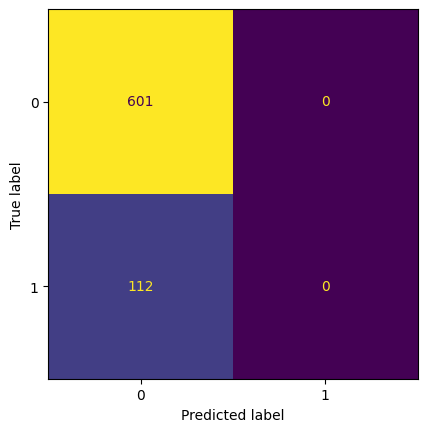

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

baseline_matrix = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_dummy,
    colorbar=None
)

plt.show()

Tampak bahwa `DummyClassifier` sebagai baseline model memprediksi dengan tepat `601` observasi pelanggan Telecom sebagai non-churn (True negative: `0` true label that is also predicted as `0`), tetapi salah mengklasifikasi `112` pelanggan (False negative: `1` true label yang tetap diprediksi sebagai `0`).

Karena model ini hanya menghasilkan negative predictions, maka Negative Prediction Value (NPV) dapat digunakan untuk mengukur how many predictions out of all negative predictions were correct. It tells us what is the fraction of correctly predicted non-churned customers in all non-churned predictions.

$$ {NPV} = \frac{TN}{TN + FN} $$

In [14]:
# TN = 601
# FN = 112

601 / (601 + 112)

0.8429172510518934

Nilai NPV tersebut selaras dengan apa yang telah disampaikan dalam bagian `Target Variable` in the previous `Section 3`. Namun demikian, NPV —seperti halnya metrik derivatif lainnya dari confusion matrix seperti accuracy, precision, dan recall— adalah [discontinuous evaluation metric](https://hbiostat.org/blog/post/class-damage/).
* These evaluation metrics implicitly or explicitly uses [probability thresholds](https://scikit-learn.org/stable/modules/classification_threshold.html) (akan ditunjukkan lebih lanjut pada bagian berikutnya dalam project ini), and varying these thresholds just a tiny little bit may make the predictions change classes, and change the metrics by a discrete amount.
* Threshold-variant metrics are also not a [strictly consistent scoring rule](https://scikit-learn.org/stable/modules/model_evaluation.html#which-scoring-function-should-i-use). Proper scoring rules will prefer prediksi yang memperhitungkan probabilitas dari tiap prediksi (seperti halnya hasil yang ditunjukkan oleh `predict_proba`) and does not have a large jump because of an infinitesimal change in a predicted probability.

Dengan demikian, evaluation metrics yang akan diterapkan untuk membandingkan baseline model dengan model lainnya —dan diharapkan model lain dapat memberikan performa yang lebih baik daripada naive predictor— adalah strictly proper scoring function. Dan di antara berbagai macam fungsi tersebut seperti Brier score, logarithmic score, ranked probability score, relative operating characteristics (ROC) curves, rank histogram, and so on, the proper score function for probabilistic verification is [univocally determined](https://journals.ametsoc.org/view/journals/mwre/138/1/2009mwr2945.1.xml) to be the logarithmic score of misclassification loss a.k.a log loss:
* Also called logistic regression loss or cross-entropy loss, [log loss](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) is defined on probability estimates. It can be used to evaluate the probability outputs (`predict_proba`) of a classifier instead of its discrete predictions (`predict` outputs).
* [Conceptually](https://medium.com/data-science/intuition-behind-log-loss-score-4e0c9979680a), it is indicative of how close the prediction probability is to the corresponding actual value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value.
* For binary classification with a true label $y \in \{0, 1\}$ and a probability estimate $p = \text{Pr}(y=1)$, the log loss per sample is the negative log-likelihood of the classifier given the true label:
$$L_{log}(y,p) = -\text{log}\text{Pr}(y|p)$$
$$L_{log}(y,p) = -(y \text{log} (p) + (1-y) \text{log} (1-p))$$
* In order to evaluate a model and summarize its skill, log-loss score of the classification model is reported as average of log-losses of $N$ predictions:
$$L_{log} = \frac{1}{N} \sum\limits_{i=1}^N L_{log}(y,p)$$

In [15]:
from sklearn.metrics import log_loss

baseline_score = pd.DataFrame(
    data=[log_loss(
            y_true=y_test,
            y_pred=dummy_pipeline.predict_proba(X=X_test)
        )],
    columns=["Score"],
    index=["Log Loss"]
)

baseline_score

,Score
Log Loss,5.661836


A model with perfect skill has a log-loss score of 0. In other words, the model predicts each observation’s probability as the actual value. 
* The metric indicate how good or bad the prediction results are by denoting how far the predictions are from the actual values. 
* A model with lower log-loss score is better than the one with higher log-loss score, provided both the models are applied to the same distribution of dataset —in this case, the same training or testing set.
* Hence, the goal of training models is to minimize the [loss function](https://developers.google.com/machine-learning/crash-course/linear-regression/loss), reducing them to their lowest possible values. 

Dan setelah semua bagian dipersiapkan, we begin our overview of classification methods with one of the most popular ones – a decision tree. 

---

### Decision Tree

Decision trees are used in everyday life decisions, not just in machine learning. An example of [flow diagram](https://en.wikipedia.org/wiki/Flowchart) are actually visual representation of decision tree.

The decision tree as a machine learning algorithm is essentially the same thing as the diagram shown above; we incorporate a stream of logical rules of the form “feature $a$ value is less than $x$ and feature $b$ value is less than $y$ … -> Category 1” into a tree-like data structure.

Some advantages of decision trees yang berkaitan dengan karakteristik data input are:
* Requires little data preparation. Other predictive techniques often require data normalization (handling data with different magnitudes and/or containing outliers).
* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated. Decision tree sendiri merupakan metode supervised learning non-parametrik, sehingga tidak mempermasalahkan asumsi normalitas dalam data input.

In [16]:
from sklearn import tree

dt_classifier = tree.DecisionTreeClassifier(random_state=arbitrary_random_state)

dt_pipeline = Pipeline(
    steps=[("preprocessor", custom_preprocessor),
           ("classifier", dt_classifier)]
)

# dt_pipeline.fit(
#     X=X_train,
#     y=y_train
# )

Serupa dengan langkah yang diterapkan pada bagian `Baseline Model` sebelumnya, model decision tree dibangun dengan:
1. Menetapkan nilai arbitrary `random_state` yang sama,
2. Membuat pipeline untuk melakukan data preprocessing sebelum memasukkan raw data ke dalam classifier, dan
3. Melakukan `fit` terhadap train dataset.

Berikut juga disertakan hasil `predict_proba` dari decision tree yang diukur dengan Log Loss:

In [17]:
# dt_score = pd.DataFrame(
#     data=[log_loss(
#             y_true=y_test,
#             y_pred=dt_pipeline.predict_proba(X=X_test)
#         )],
#     columns=["Score"],
#     index=["Log Loss"]
# )

# dt_score

#### Hyperparameter Tuning

`dt_classifier` sebelumnya dibangun dengan default parameter —terkecuali untuk `random_state` yang telah diatur untuk alasan reproducibility— sebagaimana ditunjukkan berikut ini:

In [18]:
dt_pipeline["classifier"].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 0,
 'splitter': 'best'}

Secara definitif, parameter dalam models yang configurable untuk control different aspects in their training processes disebut dengan hyperparameter. Permasalahan utama yang muncul dari keberadaan hyperparameter tersebut adalah [optimizing/tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization) the set of hyperparameters that yields an optimal model which minimizes a predefined loss function on a given data set.

In the case of decision tree, the classifier provides parameters such as `min_samples_leaf` and `max_depth` to prevent a tree from overfitting. [Cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#post-pruning-decision-trees-with-cost-complexity-pruning) provides another option to control the size of a tree. In `DecisionTreeClassifier`, this pruning technique is parameterized by the cost complexity parameter, `ccp_alpha`. Greater values of `ccp_alpha` increase the number of nodes pruned.

*Notes:*
* *Because of the simplicity, the pruning technique is chosen to optimize the loss function in this project.*
* *Konsep overfitting akan ditunjukkan berikutnya dalam proses hyperparameter tuning ini, sedangkan istilah lainnya seperti tree size dan nodes akan disimpan hingga nanti jika model ini terpilih menjadi best model setelah dibandingkan evaluasinya dengan model machine learning lainnya*

In [19]:
ccp_path = dt_pipeline["classifier"].cost_complexity_pruning_path(
    X=dt_pipeline["preprocessor"].transform(X=X_train), 
    y=y_train
)

ccp_alphas = ccp_path.ccp_alphas
ccp_alphas

array([ 0.00000000e+00, -1.08420217e-19,  0.00000000e+00,  2.16840434e-19,
        2.07975875e-04,  2.16641536e-04,  2.26041576e-04,  2.33496336e-04,
        2.59969843e-04,  2.89025297e-04,  2.91166225e-04,  3.05846875e-04,
        3.28028362e-04,  3.68290612e-04,  4.09452504e-04,  4.21151146e-04,
        4.25405198e-04,  4.41948734e-04,  4.44548432e-04,  4.48447980e-04,
        4.51233371e-04,  4.59437614e-04,  4.61354934e-04,  6.23927624e-04,
        6.23927624e-04,  6.23927624e-04,  6.55423489e-04,  6.57353438e-04,
        6.89156421e-04,  7.48713149e-04,  7.48713149e-04,  7.48713149e-04,
        7.79909530e-04,  8.25144283e-04,  8.25786562e-04,  8.26908130e-04,
        8.31903499e-04,  8.54146908e-04,  8.96895960e-04,  9.02378825e-04,
        9.21276392e-04,  9.59888653e-04,  1.07682568e-03,  1.10059792e-03,
        1.14981201e-03,  1.21395894e-03,  1.23055080e-03,  1.24785525e-03,
        1.52248736e-03,  1.57806036e-03,  1.63781001e-03,  2.12397876e-03,
        2.65049254e-03,  

*Tampak bahwa nilai `ccp_alphas` terdiri dari bilangan 0, bilangan negatif, serta terindikasi adanya bilangan yang terduplikasi.*

In [20]:
ccp_alphas_series = pd.Series(data=ccp_alphas)

ccp_alphas_count = ccp_alphas_series.value_counts().to_frame()
ccp_alphas_count[ccp_alphas_count > 1]\
    .dropna()\
        .style.format_index(formatter="{:.8e}")\
            .format(formatter="{:.0f}")

,count
6.23927624e-04,3
7.48713149e-04,3
0.00000000e+00,2


*Untuk menghindari `RuntimeWarning: divide by zero encountered in scalar divide` dalam perhitungan yang dilakukan oleh `ValidationCurveDisplay` pada bagian berikutnya, maka nilai yang terduplikasi perlu dihilangkan.*

In [21]:
ccp_alphas_series.drop_duplicates(inplace=True)

ccp_alphas = ccp_alphas_series.to_numpy()
ccp_alphas

array([ 0.00000000e+00, -1.08420217e-19,  2.16840434e-19,  2.07975875e-04,
        2.16641536e-04,  2.26041576e-04,  2.33496336e-04,  2.59969843e-04,
        2.89025297e-04,  2.91166225e-04,  3.05846875e-04,  3.28028362e-04,
        3.68290612e-04,  4.09452504e-04,  4.21151146e-04,  4.25405198e-04,
        4.41948734e-04,  4.44548432e-04,  4.48447980e-04,  4.51233371e-04,
        4.59437614e-04,  4.61354934e-04,  6.23927624e-04,  6.55423489e-04,
        6.57353438e-04,  6.89156421e-04,  7.48713149e-04,  7.79909530e-04,
        8.25144283e-04,  8.25786562e-04,  8.26908130e-04,  8.31903499e-04,
        8.54146908e-04,  8.96895960e-04,  9.02378825e-04,  9.21276392e-04,
        9.59888653e-04,  1.07682568e-03,  1.10059792e-03,  1.14981201e-03,
        1.21395894e-03,  1.23055080e-03,  1.24785525e-03,  1.52248736e-03,
        1.57806036e-03,  1.63781001e-03,  2.12397876e-03,  2.65049254e-03,
        3.76992613e-03,  5.35260885e-03,  6.32101828e-03,  6.37555659e-03,
        7.52529509e-03,  

##### Validation Curve

[`ValidationCurveDisplay`](https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve) is helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

*Note on cross-validation `cv`:*

*(This also serves as continuation from the commentary in `Data Preprocessing: Train-Test Split` section above)*

*When evaluating different settings (“hyperparameters”) for estimators, seperti nilai alpha yang harus diatur secara manual untuk metode cost complexity pruning, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.*

*However, by partitioning the available data into three sets, this drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of train-validation sets.*

*A solution to this problem is a procedure called [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into $k$ smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the $k$ “folds”:*

1. *A model is trained using $k-1$ of the folds as training data;*
2. *The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as the log loss).*

*The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.*

Berikutnya, terdapat beberapa jenis [cross-validation iterators](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators), with different strategies for each of them such as `Repeated`, `ShuffleSplit`, and `Stratified`:
* `Stratified` returns each set (either train and/or test set) with approximately the same percentage of samples of each target class as the complete set. Strategi ini selaras dengan jenis data dari Iranian Telecom Churn yang memiliki proporsi target class tidak seimbang, sehingga each set yang akan digunakan dalam proses cross-validation memiliki proporsi target class yang sama.
* `ShuffleSplit` uses random sample of samples to split the dataset in each iteration of cross-validation. As the number of iterations increase, the chance of fitting the same dataset increases which is counter-intuitive to the cross-validation idea where it is preferable to get an estimate of generalizability of our model with limited amount of data (as is the case for the Churn dataset with relatively low amount of samples)
* `Repeated` repeats the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error. Berikut ditunjukkan perbandingan implementasi antara simple `StratifiedKFold` dengan `RepeatedStratifiedKFold` untuk melihat mana strategi yang memberikan hasil cross-validation terbaik.

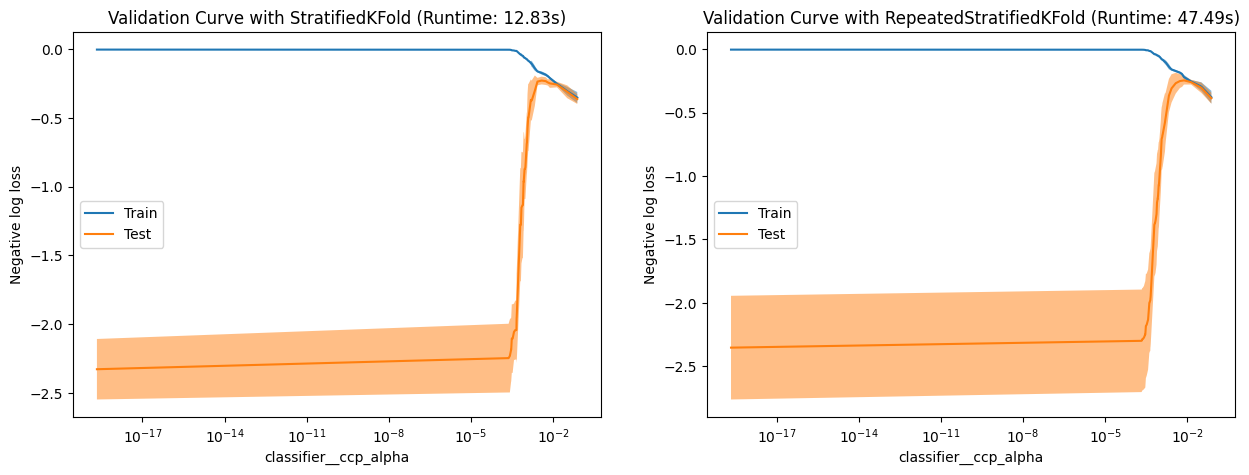

In [22]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, ValidationCurveDisplay
import time
import numpy as np

plt.figure(figsize=(15, 5))

cv1 = StratifiedKFold(n_splits=5)
ax1 = plt.subplot(1, 2, 1)
start_time1 = time.time()
ValidationCurveDisplay.from_estimator(
    estimator=dt_pipeline,
    X=X_train,
    y=y_train,
    param_name="classifier__ccp_alpha",
    param_range=np.array(object=ccp_alphas[0] + ccp_alphas[2:]),
    cv=cv1,
    scoring="neg_log_loss",
    n_jobs=-1,
    ax=ax1
)
end_time1 = time.time()
runtime1 = end_time1 - start_time1
plt.gca().set_title(label=f"Validation Curve with StratifiedKFold (Runtime: {runtime1:.2f}s)")

cv2 = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=arbitrary_random_state
)
ax2 = plt.subplot(1, 2, 2)
start_time2 = time.time()
ValidationCurveDisplay.from_estimator(
    estimator=dt_pipeline, 
    X=X_train, 
    y=y_train, 
    param_name="classifier__ccp_alpha", 
    param_range=np.array(object=ccp_alphas[0] + ccp_alphas[2:]), 
    cv=cv2,
    scoring="neg_log_loss",
    n_jobs=-1,
    ax=ax2
)
end_time2 = time.time()
runtime2 = end_time2 - start_time2
plt.gca().set_title(label=f"Validation Curve with RepeatedStratifiedKFold (Runtime: {runtime2:.2f}s)")

plt.show()

*Note:*

* *Sebagaimana yang telah disampaikan on the note for cross-validation, metode ini mengambil train set untuk dibagi menjadi $n$ smaller set (parameter `n_splits` secara default diatur sebesar 5)*
* *`ccp_alpha` yang bernilai negatif tidak disertakan pada kurva di atas karena:*
    1. *Tujuan dari cost-complexity pruning adalah meningkatkan nilai `ccp_alpha` sehingga lebih banyak nodes yang pruned, dan improve generability of the tree. Mengurangi pruned nodes dengan mengatur nilai `ccp_alpha` menjadi negatif akan bersifat counterintuitive dari konsep ini.*
    2. *Visualisasi rentang nilai dan magnitude dari `ccp_alpha` yang tidak homogen akan mengurangi interpretasi dari kurva yang dihasilkan.*
* *`scoring` yang digunakan adalah inverse dari log loss (`neg_log_loss`). Jenis metrik ini digunakan karena, pertama-tama, perlu diperhatikan bahwa all Scikit-learn's scorer objects follow the convention that [higher return values are better than lower return values](https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers). Thus metrics which measure the distance between the model and the data, like `metrics.log_loss`, are available as `neg_log_loss` which return the negated value of the metric.*
* *`n_jobs` parameter diterapkan untuk [parallelize](https://scikit-learn.org/stable/glossary.html#term-n_jobs) in training the estimator and computing the score over the different training and test sets (cross-validation sets). `-1` means using all available CPUs to concurrently process the costly cross-validation method.*

Kedua kurva di atas menunjukkan perbedaan performa dari dua implementasi strategi cross-validation: `StratifiedKFold` dan `RepeatedStratifiedKFold`
* Sumbu $x$ mewakili tiap `ccp_alphas` yang dimulai dari rentang nilai $0$, ~$2\text{x}10^{-19}$ (`2.16840434e-19`), hingga ~$7\text{x}10^{-2}$ (`7.53899088e-02`), dan sumbu $y$ adalah skor `neg_log_loss` yang dihasilkan dari tiap nilai parameter tersebut.
* Garis warna biru menunjukkan rerata skor untuk tiap nilai parameter pada data train, sedangkan garis warna oranye pada data test.
    * Khusus untuk garis warna oranye terlihat jelas area yang berwarna serupa di antara garis tersebut, yang menandakan standar deviasi around the mean score.
    * Perlu diingat sekali lagi bahwa yang dimaksud data test ini adalah data validasi (folds yang digunakan sebagai data validasi) yang bersumber dari data train.
    * Note that if we optimize the hyperparameters based on a validation score, the validation score will be biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization, it is imperative to compute the score on another test set.
* If the training score (losses) and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well.

Tampak bahwa wujud kedua kurva hampir serupa. Dimulai dari nilai parameter paling kiri/rendah, the tree overfits, leading to a zero training loss and more than `-2` testing (validation) log loss. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better (increasing the testing score while also reducing the training score). But up until a certain point, both of the losses decreases, indicating an underfit. Tahapan berikutnya dapat digunakan untuk mencari nilai parameter yang dapat memaksimalkan skor pada validation set.

Di samping itu, `RepeatedStratifiedKFold` menunjukkan rerata skor testing yang sedikit lebih tinggi daripada `StratifiedKFold`, namun dengan rentang standar deviasi yang lebih lebar (menandakan bahwa skor yang dihasilkan justru bervariatif dan tidak stabil) serta memakan runtime yang jauh lebih besar (more than 3-4 times). Berdasarkan temuan-temuan ini, dipertimbangkan untuk bagian-bagian selanjutnya yang membutuhkan metode cross-validation agar cukup menggunakan metode `StratifiedKFold`.

In [23]:
# Using `StratifiedKFold` as the preferred cross-validation method in further sections
cv = StratifiedKFold(n_splits=5)

##### Grid Search CV

Two generic approaches to hyper-parameter search for the best cross-validation score are provided in Scikit-learn: for given values, `GridSearchCV` exhaustively considers all parameter combinations (costly), while `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution.

Karena dalam metode cost-complexity pruning hanya mengimplementasikan satu jenis parameter `ccp_alpha`, maka pendekatan `GridSearchCV` dapat digunakan untuk mencari nilai alpha terbaik dari seluruh parameter space yang tersedia dan diharapkan tidak menggunakan computational budget yang besar.

In [24]:
from sklearn.model_selection import GridSearchCV

dt_param = {"classifier__ccp_alpha": np.array(object=ccp_alphas[0] + ccp_alphas[2:])}

dt_grid = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=cv,
    refit=True
)

dt_grid.fit(
    X=X_train,
    y=y_train
)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__ccp_alpha': array([2.16840434e-19, 2.07975875e-04, 2.16641536e-04, 2.26041576e-04,
       2.33496336e-04, 2.59969843e-04, 2.89025297e...
       9.02378825e-04, 9.21276392e-04, 9.59888653e-04, 1.07682568e-03,
       1.10059792e-03, 1.14981201e-03, 1.21395894e-03, 1.23055080e-03,
       1.24785525e-03, 1.52248736e-03, 1.57806036e-03, 1.63781001e-03,
       2.12397876e-03, 2.65049254e-03, 3.76992613e-03, 5.35260885e-03,
       6.32101828e-03, 6.37555659e-03, 7.52529509e-03, 1.36771241e-02,
       3.23759397e-02, 7.53899088e-02])},
             scoring='neg_log_loss')

In [25]:
pd.DataFrame(
    data=[
        abs(dt_grid.best_score_), 
        dt_grid.best_params_["classifier__ccp_alpha"]
    ],
    index=[
        "Best CV Score",
        "Best CV Parameter"
    ],
    columns=["Value"]
)

,Value
Best CV Score,0.229332
Best CV Parameter,0.003770


*Note:*

* *`dt_param` adalah parameter space untuk `DecisionTreeClassifier` yang serupa dengan implementasi sebelumnya pada bagian `Hyperparameter Tuning`.*
* *Karena `GridSearchCV` mengimplementasikan `estimator` ke dalam parameternya, maka pendekatan ini juga menerapkan metode selayaknya estimator seperti `fit` dan `score`.*
    * *Metrik yang digunakan dalam `score` akan bergantung pada parameter `scoring` yang diterapkan.*
    * *The parameter(s) of the estimator used to apply these methods are optimized by `cv` grid-search over the `param_grid`.*
* *2 dari beberapa attribute (output) yang dihasilkan oleh `GridSearchCV` adalah:*
    1. *`best_score_`: Mean cross-validated score of the `estimator(s)`, and*
    2. *`best_params_`: Parameter setting that gave the best results/score on the holdout data.*
* *Setelah `best_params_` ditemukan, parameter `refit` berguna untuk menerapkan kembali (`fit`) parameter terbaik ini ke dalam `estimator` on the whole dataset, sebagaimana ditunjukkan pada tampilan berikut:*

In [26]:
dt_grid.best_estimator_["classifier"]

DecisionTreeClassifier(ccp_alpha=np.float64(0.0037699261278164795),
                       random_state=0)

#### Model Evaluation

Setelah didapatkan nilai terbaik dari parameter space yang ditentukan, berikutnya evaluasi model dapat dilakukan dengan membandingkan score/losses yang didapatkan during the grid search process —from the holdout/validation samples— with score from the evaluation/testing set.

In [27]:
dt_grid_test_score = log_loss(
    y_true=y_test,
    y_pred=dt_grid.predict_proba(X=X_test)
)

pd.DataFrame(
    data=[
        abs(dt_grid.best_score_),
        dt_grid_test_score
    ],
    index=[
        "CV Score",
        "Test Score"
    ],
    columns=["Log Loss"]
)

,Log Loss
CV Score,0.229332
Test Score,0.211254


Log loss score pada cross-validation set merepresentasikan in-sample performance of the `DecisionTreeClassifier` (acting as the training set), while score on the testing set represents out-of sample performance. Scores tersebut menunjukkan bahwa **model generalizes well from "seen" data to "new" data**, karena:
* Tidak ada indikasi bahwa model performs well on the training set (low train score/loss) but poorly on the test set (high train score), karena both scores are relatively the same; and
* Tidak ada indikasi bahwa model performs poorly on all sets, especially when this score dibandingkan dengan test serupa pada baseline dan untuned `DecisionTreeClassifier` (test score on tuned `DecisionTreeClassifier` is the lowest amongst all):

In [28]:
dt_score_tuned = pd.DataFrame(
    data=[dt_grid_test_score],
    columns=["Score"],
    index=["Log Loss"]
)

# pd.concat(
#     objs=[baseline_score.rename(columns={"Score": "Baseline"}),
#           dt_score.rename(columns={"Score": "Decision Tree"}),
#           dt_score_tuned.rename(columns={"Score": "Decision Tree (Tuned)"})],
#     axis=1
# ).T

Berikut juga disertakan confusion matrix untuk tuned `DecisionTreeClassifier` sebagai ukuran tambahan dari kinerja model tersebut:

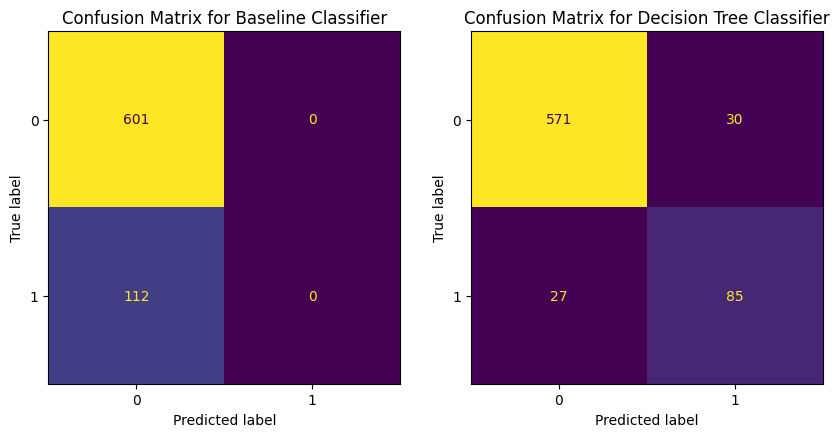

In [29]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
baseline_matrix = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_dummy,
    ax=ax1,
    colorbar=None
)
plt.gca().set_title(label=f"Confusion Matrix for Baseline Classifier")

ax2 = plt.subplot(1, 2, 2)
dt_tuned_matrix = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=dt_grid.predict(X=X_test),
    ax=ax2,
    colorbar=None
)
plt.gca().set_title(label=f"Confusion Matrix for Decision Tree Classifier")

plt.show()

These confusion matrixes dapat dianalisis dari dua sisi:
1. Actual Negatives (baris pertama): jika dibandingkan dengan `DummyClassifier`, performa `DecisionTreeClassifier` sedikit lebih buruk, karena terdapat `30` negative samples yang salah diprediksi (False Positives)
2. Actual Positives (baris kedua): secara signifikan `DecisionTreeClassifier` mampu memprediksi dengan tepat `85` positive samples (True Positives), dan hanya menyisakan 25 positive samples yang salah diprediksi (False Negatives)

Dengan mempertimbangkan bahwa fokus utama dari project ini adalah churned customers (class/label `1`), maka secara intuitif dapat dikatakan bahwa model yang dapat memprediksi churn dengan baik (`TP`) adalah best model among others. Dan dengan demikian, `DecisionTreeClassifier` model dapat ditetapkan menjadi model terbaik yang dapat menggantikan baseline `DummyClassifier` model.

*Note:*
* *Perlu diingat bahwa confusion matrix juga termasuk ke dalam threshold-variant metrics, dan nilai yang dihasilkan dapat berubah sesuai nilai threshold yang ditetapkan.*
* *Metric ini ditampilkan dengan maksud untuk memudahkan pemahaman dan perbandingan kinerja antara baseline dan decision tree, serta menambahkan penjelasan disamping skor log-loss yang dinilai kurang interpretatif. Model terbaik tetap akan ditentukan berdasarkan skor log loss terendah.*

Analisis model klasifikasi berikutnya akan dilanjutkan with another very popular classification method: the nearest neighbors method.

#### Model Experimentation

An [experiment](https://en.wikipedia.org/wiki/Experiment) is a procedure carried out to support or refute a hypothesis, or determine the efficacy or likelihood of something previously untried. Experiments provide insight into cause-and-effect by demonstrating what outcome occurs when a particular factor is manipulated. Experiments vary greatly in goal and scale but always rely on repeatable procedure and logical analysis of the results. 

Langkah-langkah yang telah dilakukan sebelumnya —mulai dari menetapkan baseline performance hingga melakukan hyperparameter optimization pada model pertama dan membandingkannya dengan benchmark model— dapat dkatakan sebagai bentuk dari eksperimen dalam machine learning. When running experiments, [the goal](https://developers.google.com/machine-learning/managing-ml-projects/experiments) is to make continual, incremental improvements by evaluating a variety of model architectures and features.

Ada beragam metode dan perubahan yang dapat dilakukan untuk meningkatkan performa model, seperti data transformation, feature selection, feature crossing, and various other feature engineering practices. Sekilas eksperimentasi sebelumnya telah menerapkan feature selection untuk menghapus correlated features dari modeling dataset (`Age` dan `Age Group`), dan langkah eksploratif seperti [feature interaction](https://developers.google.com/machine-learning/crash-course/categorical-data/feature-crosses) dapat dilakukan untuk menerapkan domain knowledge kepada dataset sehingga ditemukan useful combination of features to cross. Experiments berikutnya akan berfokus pada anomali yang telah ditemukan pada bagian `Data Analysis` sebelumnya dan mencari tahu apakah penanganan to those anomalies akan memberikan dampak pada model.

Terdapat beberapa pertimbangan sebelum melakukan eksperimentasi dengan `DecisionTreeClassifier`:

* Decision Trees are [not sensitive to feature scaling](https://forecastegy.com/posts/do-decision-trees-need-feature-scaling-or-normalization/) because their splits don’t change with any monotonic transformation. Hence, experimenting this way would be unnecessary dan sebaiknya waktu dan sumber daya yang digunakan dalam project ini dialihkan pada eksperimentasi pada anomali data lainnya.
* Pun demikian halnya dengan permasalahan outlier, karena in general, Decision Trees are quite [robust to the presence of outliers](https://insidelearningmachines.com/decision_trees_robust_to_outliers/) in the data.
* Sebagaimana yang telah disampaikan di awal pembahasan mengenai `Decision Tree`, metode ini termasuk ke dalam metode non-parametric supervised learning, sehingga tidak mempermasalahkan ada atau tidaknya asumsi normalitas dalam data, ataupun membutuhkan normalisasi data input.

Dengan demikian, selain anomalies yang telah disebutkan, eksperimen akan dilakukan untuk mencari tahu apakah penanganan terhadap anomali tertentu dapat meningkatkan performa model atau tidak.

| Anomaly | Checklist |
| --- | --- |
| Cardinality | <div style="text-align: center"> ✓ </div> |
| Variable Magnitude | <div style="text-align: center"> - </div> |
| Outlier | <div style="text-align: center"> - </div> |
| Normality | <div style="text-align: center"> - </div> |
| Rare Label | <div style="text-align: center"> ✓ </div> |
| Imbalanced Data | <div style="text-align: center"> ✓ </div> |

##### Experiment 1: Cardinality & Rare Label

Melanjutkan pembahasan pada `Section 2 & 3: Data Analysis`, high cardinality and rare label instances may pose the following problems:
* Variables with too many labels tend to dominate over those with only a few labels, particularly in Tree-based algorithms.
* A big number of labels —even more so if those labels are infrequent— within a variable may introduce noise with little, if any, information; making machine learning models prone to over-fit.
* Some of the labels may only be present in the training data set, but not in the test set, therefore machine learning algorithms may over-fit to the training set.
* Contrarily, some labels may appear only in the test set, therefore leaving the models unable to perform a calculation over the new (unseen) observation.

Note that sometimes rare values are indeed important. For example, if we are building a model to predict customers intending to churn —which are by nature rare—, then a rare value in a certain variable may be indeed very predictive. This rare value could be telling us that the observation is most likely to churn, and therefore we would choose not to ignore it.

In [33]:
import numpy as np

class Exp1Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X = X.copy()

        X_columns_splitted = X.columns.str.split()
        X.columns = X_columns_splitted.str.join(sep=" ")

        def rare_encode(X, column, new_label=9):

            value_counts = X[column].value_counts(normalize=True)
            threshold = X[column].value_counts(normalize=True).mean()
            rare_labels = value_counts[value_counts < threshold].index

            if X.nunique()[X.nunique() > 2].any():
                X[column] = np.where(X[column].isin(rare_labels), new_label, X[column])
            else:
                pass

            return X

        categorical_columns = ["Tariff Plan", "Status", "Charge Amount", "Age Group", "Age"]
        for column in categorical_columns:
            X[column] = X[column].astype(dtype="object")
            X = rare_encode(X=X, column=column)
            X[column] = X[column].astype(dtype="int")

        X = X.drop(columns="Age")

        return X
    
exp1_preprocessor = Exp1Preprocessor()

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

exp1_pipeline = Pipeline(
    steps=[("preprocessor", exp1_preprocessor),
           ("scaler", standard_scaler),
           ("classifier", dt_classifier)]
)

exp1_pipeline.fit(
    X=X_train,
    y=y_train
)

Pipeline(steps=[('preprocessor', Exp1Preprocessor()),
                ('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [ ]:
# exp1_score = pd.DataFrame(
#     data=[log_loss(
#             y_true=y_test,
#             y_pred=exp1_pipeline.predict_proba(X=X_test)
#         )],
#     columns=["Score"],
#     index=["Log Loss"]
# )

# exp1_score

In [36]:
exp1_pipeline[0:2]

Pipeline(steps=[('preprocessor', Exp1Preprocessor()),
                ('scaler', StandardScaler())])

In [37]:
exp1_ccp_path = exp1_pipeline["classifier"].cost_complexity_pruning_path(
    X=exp1_pipeline[:2].transform(X=X_train), 
    y=y_train
)

exp1_ccp_alphas = exp1_ccp_path.ccp_alphas
exp1_ccp_alphas

array([ 0.00000000e+00, -1.08420217e-19,  0.00000000e+00,  2.16840434e-19,
        2.07975875e-04,  2.16641536e-04,  2.26041576e-04,  2.59969843e-04,
        2.89025297e-04,  3.05846875e-04,  3.10274477e-04,  3.68290612e-04,
        4.09452504e-04,  4.21151146e-04,  4.25405198e-04,  4.41948734e-04,
        4.44548432e-04,  4.48447980e-04,  4.51233371e-04,  4.59437614e-04,
        4.61354934e-04,  6.23927624e-04,  6.23927624e-04,  6.23927624e-04,
        6.55423489e-04,  6.57353438e-04,  6.89156421e-04,  7.01918577e-04,
        7.48713149e-04,  7.48713149e-04,  7.48713149e-04,  7.79909530e-04,
        8.25144283e-04,  8.26908130e-04,  8.31903499e-04,  8.31903499e-04,
        8.54146908e-04,  8.96895960e-04,  9.02378825e-04,  9.59888653e-04,
        1.05287787e-03,  1.07682568e-03,  1.10059792e-03,  1.14981201e-03,
        1.16535607e-03,  1.23055080e-03,  1.24785525e-03,  1.52248736e-03,
        1.57806036e-03,  1.63781001e-03,  2.23944357e-03,  2.65049254e-03,
        3.76992613e-03,  

In [ ]:
exp1_param = {"classifier__ccp_alpha": np.array(object=exp1_ccp_alphas[0] + exp1_ccp_alphas[2:])}

exp1_grid = GridSearchCV(
    estimator=exp1_pipeline,
    param_grid=exp1_param,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=cv,
    refit=True
)

exp1_grid.fit(
    X=X_train,
    y=y_train
)

pd.DataFrame(
    data=[
        abs(exp1_grid.best_score_), 
        exp1_grid.best_params_["classifier__ccp_alpha"]
    ],
    index=[
        "Best CV Score",
        "Best CV Parameter"
    ],
    columns=["Value"]
)

,Value
Best CV Score,0.229332
Best CV Parameter,0.003770


In [ ]:
exp1_grid_test_score = log_loss(
    y_true=y_test,
    y_pred=exp1_grid.predict_proba(X=X_test)
)

pd.DataFrame(
    data=[
        abs(exp1_grid.best_score_),
        exp1_grid_test_score
    ],
    index=[
        "CV Score",
        "Test Score"
    ],
    columns=["Log Loss"]
)

,Log Loss
CV Score,0.229332
Test Score,0.211254


---

### Nearest Neighbor

This method, like decision trees, is one of the most comprehensible approaches to classification. The underlying intuition is that you look like your neighbors. More formally, the method follows the compactness hypothesis: if the distance between the examples is measured well enough, then similar examples are much more likely to belong to the same class.

For a real-life example, if we do not know how to tag a Bluetooth-headset on an online listing, we can find 5 similar headsets, and, if 4 of them are tagged as "accessories" and only 1 as "Technology", then we will also label it under "accessories".

To classify each sample from the test set, one needs to perform the following operations in order:
1. Calculate the distance to each of the samples in the training set.
2. Select $ k $ samples from the training set with the minimal distance to them.
3. The class of the test sample will be the most frequent class among those $ k $ nearest neighbors.

In [ ]:
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

kn_classifier = neighbors.KNeighborsClassifier(n_jobs=-1)
standard_scaler = StandardScaler()

kn_pipeline = Pipeline(
    steps=[("preprocessor", custom_preprocessor),
           ("scaler", standard_scaler),
           ("classifier", kn_classifier)]
)

kn_pipeline.fit(
    X=X_train,
    y=y_train
)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
kn_score = pd.DataFrame(
    data=[log_loss(
            y_true=y_test,
            y_pred=kn_pipeline.predict_proba(X=X_test)
        )],
    columns=["Score"],
    index=["Log Loss"]
)

kn_score

,Score
Log Loss,0.329593


In [ ]:
kn_pipeline["classifier"].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

<div>
    <a href="../notebook/2. Data Analysis.ipynb" style="float: left; padding: 10px; background-color: #007bff; color: white;">Previous</a>
    <a href="../notebook/1. Business & Data Understanding.ipynb" style="float: right; padding: 10px; background-color: #007bff; color: white"> Next </a>
</div>